# PREDINCTING HOSPITAL LENGTH OF STAY

## Third code developing 4-class classification model (short time intervals)

In [ ]:
#importing the necessary libraries
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification

In [2]:
mod = pd.read_csv('comobid.csv') #importing already cleaned and saved data for modeling

In [3]:
mod =mod[['age','los','discharge_location','admission_location','admission_type','insurance','num_comorbidities','diagnosis','religion']]
mod #selecting best predictors which  for model fitting

,age,los,discharge_location,admission_location,admission_type,insurance,num_comorbidities,diagnosis,religion
0,25.0,7.0,HOME HEALTH CARE,EMERGENCY ROOM ADMIT,EMERGENCY,Medicaid,11,HYPERTENSION,NOT SPECIFIED
1,48.0,8.0,HOME WITH HOME IV PROVIDR,EMERGENCY ROOM ADMIT,EMERGENCY,Private,9,"FEVER,DEHYDRATION,FAILURE TO THRIVE",PROTESTANT QUAKER
2,66.0,16.0,HOME HEALTH CARE,PHYS REFERRAL/NORMAL DELI,ELECTIVE,Medicare,8,CHRONIC RENAL FAILURE/SDA,NOT SPECIFIED
3,42.0,5.0,DEAD/EXPIRED,EMERGENCY ROOM ADMIT,EMERGENCY,Medicaid,6,HEMORRHAGIC CVA,UNOBTAINABLE
4,50.0,26.0,HOME HEALTH CARE,EMERGENCY ROOM ADMIT,EMERGENCY,Private,1,BRAIN MASS,OTHER
...,...,...,...,...,...,...,...,...,...
38632,67.0,13.0,HOME HEALTH CARE,PHYS REFERRAL/NORMAL DELI,ELECTIVE,Medicare,10,ATRIAL FIBRILLATION\BILATERAL THORACOSCOPIC MI...,CATHOLIC
38633,79.0,5.0,HOME HEALTH CARE,PHYS REFERRAL/NORMAL DELI,ELECTIVE,Medicare,6,LEFT BRAIN TUMOR/SDA,PROTESTANT QUAKER
38634,67.0,8.0,DEAD/EXPIRED,CLINIC REFERRAL/PREMATURE,EMERGENCY,Medicare,24,STROKE;TELEMETRY,PROTESTANT QUAKER
38635,32.0,2.0,HOME,EMERGENCY ROOM ADMIT,EMERGENCY,Private,8,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,NOT SPECIFIED


In [4]:
# Import the LabelEncoder class from the scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
le = LabelEncoder()

# Loop through each column in the 'model_data' DataFrame
for i in mod.columns:
    
    # Check if the column datatype is 'object'
    if mod[i].dtypes == 'object':
        
        # Use the LabelEncoder instance to transform the values in the current column to numerical values
        # The 'reshape' method is used to ensure that the input to the 'fit_transform' method is a 2D array
        mod[i]=le.fit_transform(mod[i].values.reshape(-1,1))


In [5]:
#drop all los with -1 values(these could be input error or deceased patients)
expired = mod.loc[mod['los'] == -1]
mod= mod.drop(expired.index)
mod['los'].unique()

array([  7.,   8.,  16.,   5.,  26.,  13.,   4.,   2.,   6.,  15.,   3.,
        18.,  23.,  29.,   9.,  11.,  27.,  10.,   1.,  19.,  25.,  14.,
        17.,  33.,   0.,  77.,  12.,  24.,  36.,  22.,  21.,  48.,  28.,
        32.,  81.,  30.,  61.,  31.,  49.,  76.,  20.,  39.,  44.,  53.,
        55.,  50.,  35.,  34.,  66.,  37.,  42.,  87.,  64.,  86.,  59.,
        38.,  71.,  84.,  57.,  41.,  83., 164.,  51.,  45.,  54.,  58.,
        52.,  91.,  62.,  96.,  73.,  88.,  47.,  40.,  75.,  65.,  56.,
       191., 130.,  68.,  63.,  70., 101., 124.,  67., 156.,  46., 100.,
        74., 125.,  43., 182., 203., 154., 138.,  85., 110., 103.,  97.,
        89., 129., 167.,  79., 172., 107., 104., 108.,  60.,  92.,  72.,
       163.,  78., 162.,  93., 112., 106., 127., 146.,  80.,  94., 123.,
       113., 102., 131.,  95.,  98.,  69., 132., 206.,  82.])

In [6]:
# setting an abitrary cuttoff for los 1 for short stay, 2 for intermediate stay, 3 for prolonged and 4 for extended stay 
los_category = []
for row in mod['los']:
    if  0<= row <= 10:
        los_category.append(1) #short
    elif 10 < row <= 30:
        los_category.append(2) #intermediate
    elif 30 < row <= 60:
        los_category.append(3)# prolonged
    else:
        los_category.append(4) #extendended
mod['los_category'] = los_category # adding a new column to the dataset this will be my target variable
mod


,age,los,discharge_location,admission_location,admission_type,insurance,num_comorbidities,diagnosis,religion,los_category
0,25.0,7.0,5,2,1,1,11,5638,14,1
1,48.0,8.0,6,2,1,3,9,4814,16,1
2,66.0,16.0,5,4,0,2,8,3012,14,2
3,42.0,5.0,0,2,1,1,6,5397,19,1
4,50.0,26.0,5,2,1,3,1,2046,15,2
...,...,...,...,...,...,...,...,...,...,...
38632,67.0,13.0,5,4,0,2,10,1642,3,2
38633,79.0,5.0,5,4,0,2,6,6466,16,1
38634,67.0,8.0,0,1,1,2,24,11215,16,1
38635,32.0,2.0,4,2,1,3,8,11222,14,1


In [7]:
# defininig dependent and independent variables
y_b = mod['los_category']#dependent variables
X = mod.drop(['los_category','los'], axis =1) #independent variables

In [8]:
y = y_b.copy() # making a copy of dependent variable

In [9]:
mod.shape

(38624, 10)

In [10]:
#normalising the input variables using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-2.22385783, -0.34211169, -0.49670205, ..., -0.097621  ,
        -0.14328296,  0.60886104],
       [-0.91065282, -0.14478594, -0.49670205, ..., -0.40947853,
        -0.36710319,  0.93211617],
       [ 0.11707285, -0.34211169,  0.86039624, ..., -0.56540729,
        -0.85657414,  0.60886104],
       ...,
       [ 0.17416872, -1.32874048, -1.1752512 , ...,  1.92945294,
         1.37157803,  0.93211617],
       [-1.82418674, -0.53943745, -0.49670205, ..., -0.56540729,
         1.37347942,  0.60886104],
       [-0.33969411, -0.53943745, -1.1752512 , ..., -0.40947853,
        -1.61414045,  0.60886104]])

In [11]:
#oversampling the data
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X,y = sm.fit_resample(X,y)

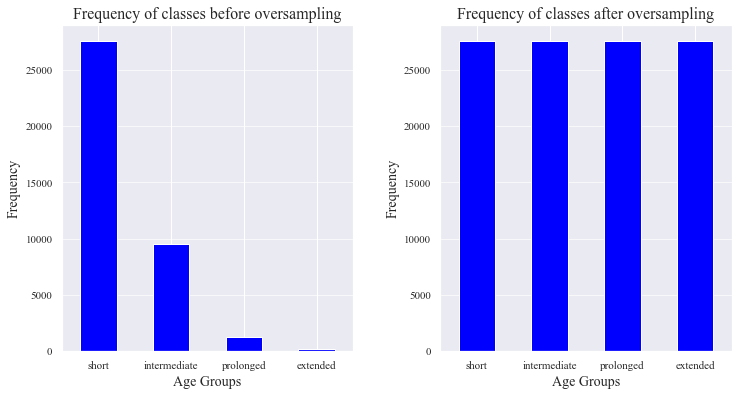

In [12]:
#visualizing the output variable before and after applying SMOTE



# Set the font to a consistent font with the paper
sns.set(font='Times New Roman')

# Create the subplots with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Modify x-tick labels to "young", "mid-age", and "old"
xtick_labels = ['short', 'intermediate', 'prolonged','extended']

# Plot the first bar chart
y_b.value_counts().plot(kind='bar', color='blue', ax=axs[0])

# Add the grid and labels
axs[0].grid(axis='y', alpha=0.7)
axs[0].set_xlabel('Age Groups', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Frequency of classes before oversampling', fontsize=16)
axs[0].set_xticklabels(xtick_labels, rotation=0)

# Plot the second bar chart
y.value_counts().plot(kind='bar', color='blue', ax=axs[1])

# Add the grid and labels
axs[1].grid(axis='y', alpha=0.7)
axs[1].set_xlabel('Age Groups', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Frequency of classes after oversampling', fontsize=16)
axs[1].set_xticklabels(xtick_labels, rotation=0)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Show the chart
plt.show()


## Logistics Regression(LR)

In [25]:

# Import the necessary libraries for the code
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score

# Create an instance of the OneVsRestClassifier class with LogisticRegression as the estimator
lr = OneVsRestClassifier(LogisticRegression())

# Loop through 100 random states
for i in range(0,100):
    
    # Split the data into training and testing sets with a test size of 20% and the current random state
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =i, test_size = 0.20)
    
    # Fit the OneVsRestClassifier model on the training data
    lr.fit(X_train,y_train)
    
    # Predict the classes for the training and testing data
    pred_train= lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    # Check if the training and testing accuracies are equal up to 1 decimal place
    if round(accuracy_score(y_train,pred_train)*100,1)== round(accuracy_score(y_test,pred_test)*100,1):
        
        # Print the model performance metrics for the current random state
        print('At random state',i, 'the model reports:')
        print('At random state:-', i)
        print('Training accuracy is:', accuracy_score(y_train,pred_train)*100)
        print('Testing accuracy is:', accuracy_score(y_test,pred_test)*100)
        print('\n')


At random state 14 the model reports:
At random state:- 14
Training accuracy is: 41.14956582775759
Testing accuracy is: 41.122130145360686


At random state 26 the model reports:
At random state:- 26
Training accuracy is: 41.12692320755358
Testing accuracy is: 41.14477199655844


At random state 33 the model reports:
At random state:- 33
Training accuracy is: 41.194851068165605
Testing accuracy is: 41.221754290630805


At random state 37 the model reports:
At random state:- 37
Training accuracy is: 41.141640910686185
Testing accuracy is: 41.14477199655844


At random state 42 the model reports:
At random state:- 42
Training accuracy is: 41.19258680614521
Testing accuracy is: 41.21722592039126


At random state 56 the model reports:
At random state:- 56
Training accuracy is: 41.24240057059403
Testing accuracy is: 41.16741384775619


At random state 62 the model reports:
At random state:- 62
Training accuracy is: 41.23787204655323
Testing accuracy is: 41.16741384775619


At random state 

In [14]:
# calulating classification metric report for each class
class_names = ['short', 'intermediate', 'prolonged','extended']
print(classification_report(y_test,pred_test,target_names=class_names))

              precision    recall  f1-score   support

       short       0.46      0.69      0.55      5455
intermediate       0.36      0.29      0.32      5607
   prolonged       0.34      0.16      0.22      5489
    extended       0.40      0.50      0.45      5532

    accuracy                           0.41     22083
   macro avg       0.39      0.41      0.38     22083
weighted avg       0.39      0.41      0.38     22083



In [15]:
# Predict the classes for the testing data using the trained model
pred_lr = lr.predict(X_test)

# Import the necessary libraries for cross-validation
from sklearn.model_selection import cross_val_score

# Compute the accuracy score for the predicted labels and the actual labels
lss = accuracy_score(y_test,pred_lr)

# Loop through cross-validation folds from 2 to 9
for i in range(2,10):
    
    # Compute the cross-validation score for the current number of folds
    lsscore = cross_val_score(lr,X,y, cv =i)
    
    # Compute the mean cross-validation score across all folds
    lsc = lsscore.mean()
    
    # Print the cross-validation and accuracy scores for the current number of folds
    print('At cv:',i)
    print('cross validation score is:-', lsc*100)
    print('accuracy_score is:-',lss*100)
    print('\n')


At cv: 2
cross validation score is:- 39.90327138354527
accuracy_score is:- 40.759860526196626


At cv: 3
cross validation score is:- 40.73379705104518
accuracy_score is:- 40.759860526196626


At cv: 4
cross validation score is:- 40.656812665290005
accuracy_score is:- 40.759860526196626


At cv: 5
cross validation score is:- 40.61059098972115
accuracy_score is:- 40.759860526196626


At cv: 6
cross validation score is:- 40.73017425642141
accuracy_score is:- 40.759860526196626


At cv: 7
cross validation score is:- 40.85333533303118
accuracy_score is:- 40.759860526196626


At cv: 8
cross validation score is:- 40.87955073692706
accuracy_score is:- 40.759860526196626


At cv: 9
cross validation score is:- 40.877803137340145
accuracy_score is:- 40.759860526196626




In [16]:
pred_prob = lr.predict_proba(X_test) # calculating predicted probabilities and checking the shape
pred_prob.shape

(22083, 4)

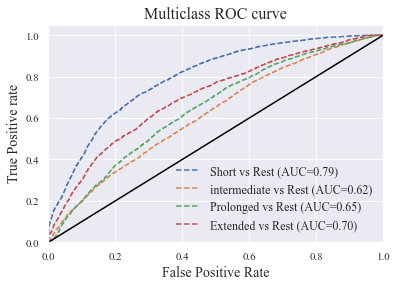

In [17]:
# Plottin ROC AUC curves 

import numpy as np                   # import numpy library for numerical operations
import matplotlib.pyplot as plt      # import pyplot module from matplotlib for plotting
from sklearn.metrics import roc_curve, auc   # import required metrics for computing ROC curve

classes = np.unique(y_test)          # get unique classes in y_test variable
class_names = ['Short','intermediate','Prolonged','Extended'] # create list of class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))   # binarize y_test variable

# roc curves for each class
fpr = {}     # dictionary to store false positive rate for each class
tpr = {}     # dictionary to store true positive rate for each class
threshold = {}  # dictionary to store threshold values for each class
roc_auc = {}    # dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]     # get number of classes

# calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)' % (class_names[i], roc_auc[i]))

# plot diagonal line representing no skill
plt.plot([0, 1], [0, 1], 'black')

# set plot limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Multiclass ROC curve',fontsize=16)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive rate',fontsize=14)

# add legend to the plot
plt.legend(loc='lower right',frameon=False,fontsize=12)

# show the plot
plt.show()



## Support Vector Machine 

In [18]:
#developing a support vector model and checking the accuracy

from sklearn.svm import SVC  # import the support vector machine classifier

svc = OneVsRestClassifier(SVC())  # create an instance of the one-vs-rest classifier with the support vector machine as the base estimator

svc.fit(X_train, y_train)  # fit the one-vs-rest classifier to the training data

predsvc = svc.predict(X_test)  # make predictions on the test data using the fitted classifier

print(accuracy_score(y_test, predsvc))  # print the accuracy score of the predictions

print(confusion_matrix(y_test,predsvc))  # print the confusion matrix of the predictions

print(classification_report(y_test,predsvc))  # print the classification report of the predictions


0.6221980709142779
[[4003  519  538  395]
 [2112 1104 1424  967]
 [ 612  317 3524 1036]
 [ 118   71  234 5109]]
              precision    recall  f1-score   support

           1       0.58      0.73      0.65      5455
           2       0.55      0.20      0.29      5607
           3       0.62      0.64      0.63      5489
           4       0.68      0.92      0.78      5532

    accuracy                           0.62     22083
   macro avg       0.61      0.62      0.59     22083
weighted avg       0.61      0.62      0.59     22083



In [19]:
y_score = svc.decision_function(X_test) ## predicted probabilities
y_score

array([[-1.28998878, -0.86780918,  0.48724342, -3.49111193],
       [-1.48724983, -1.02485529, -1.08521111,  0.90806628],
       [-1.36874807, -1.0075748 , -0.77618866, -1.03591704],
       ...,
       [-1.04944714, -1.08883955, -1.01124373,  0.68733741],
       [-1.33426331, -0.23058235, -1.17585041, -1.83619345],
       [-1.07291584, -0.79954145, -0.45757857, -2.14603947]])

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

import numpy as np

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

y_prob = softmax(y_score)

from scipy.special import softmax
y_prob = softmax(y_score, axis=1)
y_prob

array([[0.11696689, 0.17840755, 0.6916798 , 0.01294575],
       [0.06642573, 0.10547554, 0.09929778, 0.72880094],
       [0.17735103, 0.25450087, 0.3207591 , 0.247389  ],
       ...,
       [0.11521575, 0.11076535, 0.11970254, 0.65431636],
       [0.17264432, 0.52056484, 0.20227869, 0.10451215],
       [0.2218962 , 0.29165865, 0.41057023, 0.07587491]])

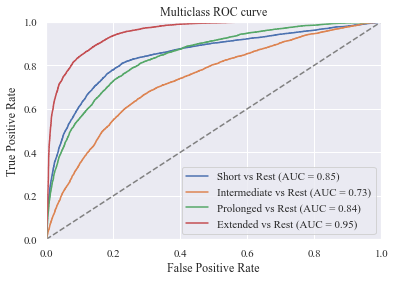

In [23]:
#visualising roc curves showing the perfomance of each class

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

classes = np.unique(y_test)
class_names = ['Short','Intermediate','Prolonged','Extended'] # list of original class names
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {} #calculating false positive rates and store in and empty dictionary
tpr = {}#calculating true positive rates and store in and empty dictionary
threshold = {}# dictionary to store threshold values for each class
roc_auc = {}# dictionary to store ROC AUC value for each class

n_classes = classes.shape[0]  #get the number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
   # Plot ROC curves
fig, ax = plt.subplots()
for i in range(n_classes):
    roc_display = plot_roc_curve(svc.estimators_[i], X_test, y_test_binarize[:, i], 
                                 name=f'{class_names[i]} vs Rest', ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [22]:
# checking cv score for support vector machine classifier
score = cross_val_score(svc,X,y)  # calculate the cross validation scores for the SVC model
print(score)  # print the array of cross validation scores
print(score.mean())  # print the mean of the cross validation scores
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predsvc)-score.mean())  # print the difference between accuracy score and mean of cross validation score

[0.62151882 0.61594892 0.62059596 0.61049724 0.61434653]
0.6165814920049328
Difference between accuracy and cross validation score is 0.005616578909345082


## Random Forest

In [26]:
#developing Random forest model

# Define an instance of OneVsRestClassifier that uses a RandomForestClassifier as the base estimator
RFC = OneVsRestClassifier(RandomForestClassifier())

# Train the classifier using the training data X_train and y_train
RFC.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predRFC = RFC.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test,predRFC))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predRFC))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predRFC))


0.8941719875016981
[[4570  768   95   22]
 [ 917 4373  260   57]
 [  58  102 5300   29]
 [   7   11   11 5503]]
              precision    recall  f1-score   support

           1       0.82      0.84      0.83      5455
           2       0.83      0.78      0.81      5607
           3       0.94      0.97      0.95      5489
           4       0.98      0.99      0.99      5532

    accuracy                           0.89     22083
   macro avg       0.89      0.89      0.89     22083
weighted avg       0.89      0.89      0.89     22083



In [27]:
pred_p = RFC.predict_proba(X_test) # calculating predicted probabilities and checking the shape
pred_p.shape
pred_p

array([[0.20634921, 0.66666667, 0.11904762, 0.00793651],
       [0.        , 0.00980392, 0.00980392, 0.98039216],
       [0.        , 0.        , 0.00990099, 0.99009901],
       ...,
       [0.        , 0.02970297, 0.        , 0.97029703],
       [0.01086957, 0.79347826, 0.18478261, 0.01086957],
       [0.39393939, 0.46464646, 0.12121212, 0.02020202]])

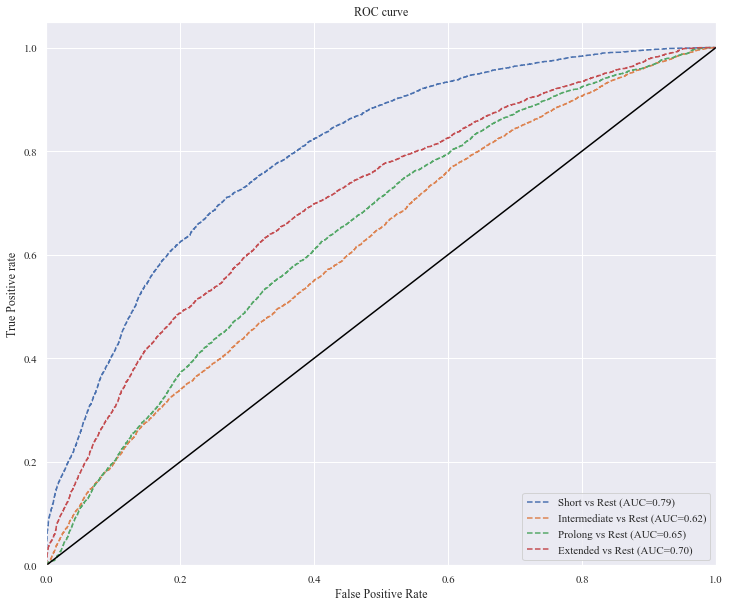

In [31]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, label_binarize

#classes = np.unique(y_test)
class_names = ['Short','Intermediate','Prolong','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

#roc curves
fpr = {}
tpr = {}
threshold = {}
roc_auc = {}

n_classes = classes.shape[0]

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))
    
#plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'black')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [32]:
score = cross_val_score(RFC,X,y)
print(score)
print(score.mean())
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predRFC)-score.mean())

[0.82642757 0.85812616 0.92228965 0.91065121 0.91314193]
0.8861273022939127
Difference between accuracy and cross validation score is 0.008044685207785451


## Gradient Booster

In [33]:
#checking accuracy for Gradient boosting classifier
#checking accuracy for Gradient boosting classifier
#checking accuracy for Gradient boosting classifier
# Define an instance of OneVsRestClassifier that uses a GradientBoostingClassifier as the base estimator
GB = OneVsRestClassifier(GradientBoostingClassifier())

# Train the classifier using the training data X_train and y_train
GB.fit(X_train,y_train)

# Use the trained classifier to make predictions on the test data X_test
predGB = GB.predict(X_test)

# Calculate and print the accuracy of the classifier's predictions on the test data
print(accuracy_score(y_test, predGB))

# Calculate and print a confusion matrix of the classifier's predictions on the test data
print(confusion_matrix(y_test,predGB))

# Calculate and print a classification report of the classifier's predictions on the test data
print(classification_report(y_test,predGB))


0.6443418013856813
[[4296  753  253  153]
 [1226 2477 1322  582]
 [ 169  885 3110 1325]
 [  51  313  822 4346]]
              precision    recall  f1-score   support

           1       0.75      0.79      0.77      5455
           2       0.56      0.44      0.49      5607
           3       0.56      0.57      0.57      5489
           4       0.68      0.79      0.73      5532

    accuracy                           0.64     22083
   macro avg       0.64      0.65      0.64     22083
weighted avg       0.64      0.64      0.64     22083



<Figure size 576x432 with 0 Axes>

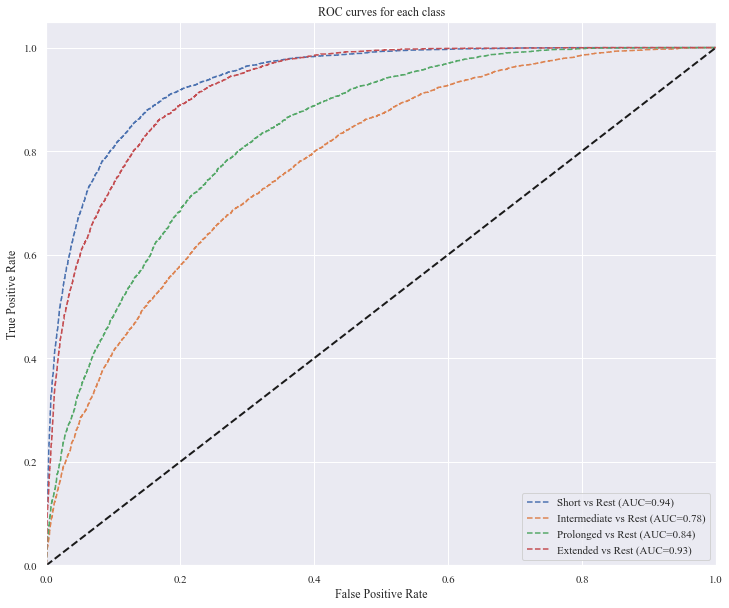

In [34]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Intermediate','Prolonged','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green', 'orange', 'purple'] # Define colors for the curves

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))




plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each class')
plt.legend(loc="lower right")
plt.show()


In [35]:
# Use cross-validation to calculate the score of the classifier on the entire dataset
score = cross_val_score(GB,X,y)

# Print the individual scores for each fold of cross-validation
print(score)

# Print the mean score across all folds of cross-validation
print(score.mean())

# Calculate and print the difference between the accuracy of the classifier's predictions on the test data and the mean score of the cross-validation
print('Difference between accuracy and cross validation score is', accuracy_score(y_test,predGB)-score.mean())


[0.59122402 0.60458271 0.65877185 0.64690698 0.64228784]
0.6287546797687786
Difference between accuracy and cross validation score is 0.015587121616902677


## Hyperparameter Tunning

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search over
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Create Random Forest Classifier object
RFC = RandomForestClassifier()

# Create GridSearchCV object
grid_rfc = GridSearchCV(estimator=RFC,
                        param_grid=param_grid,
                        cv=5, # 5-fold cross validation
                        n_jobs=-1, # use all available processors
                        scoring='accuracy')

# Fit GridSearchCV object to data
grid_rfc.fit(X, y)

# Print best hyperparameters and corresponding score
print('Best hyperparameters:', grid_rfc.best_params_)
print('Best score:', grid_rfc.best_score_)


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.6898256584840317


In [37]:
#training a model using the best parameters after hyperparameter tunning
RFC = OneVsRestClassifier(RandomForestClassifier(max_depth= 10, min_samples_split=5, n_estimators= 200))
RFC.fit(X_train,y_train)
predRFC = RFC.predict(X_test)
print(accuracy_score(y_test,predRFC))
print(confusion_matrix(y_test,predRFC))
print(classification_report(y_test,predRFC))

0.7256260471856179
[[4116  906  308  125]
 [1213 2647 1313  434]
 [ 147  520 4143  679]
 [  19  151  244 5118]]
              precision    recall  f1-score   support

           1       0.75      0.75      0.75      5455
           2       0.63      0.47      0.54      5607
           3       0.69      0.75      0.72      5489
           4       0.81      0.93      0.86      5532

    accuracy                           0.73     22083
   macro avg       0.72      0.73      0.72     22083
weighted avg       0.72      0.73      0.72     22083



In [38]:
pred_p = RFC.predict_proba(X_test)
pred_p.shape
pred_p

array([[0.10857843, 0.44236733, 0.40743195, 0.0416223 ],
       [0.04075597, 0.08502043, 0.20866947, 0.66555413],
       [0.03895341, 0.24585037, 0.35203436, 0.36316186],
       ...,
       [0.03534485, 0.20075616, 0.30005471, 0.46384428],
       [0.05358815, 0.30351578, 0.41929411, 0.22360196],
       [0.22057748, 0.34983357, 0.37161098, 0.05797797]])

<Figure size 576x432 with 0 Axes>

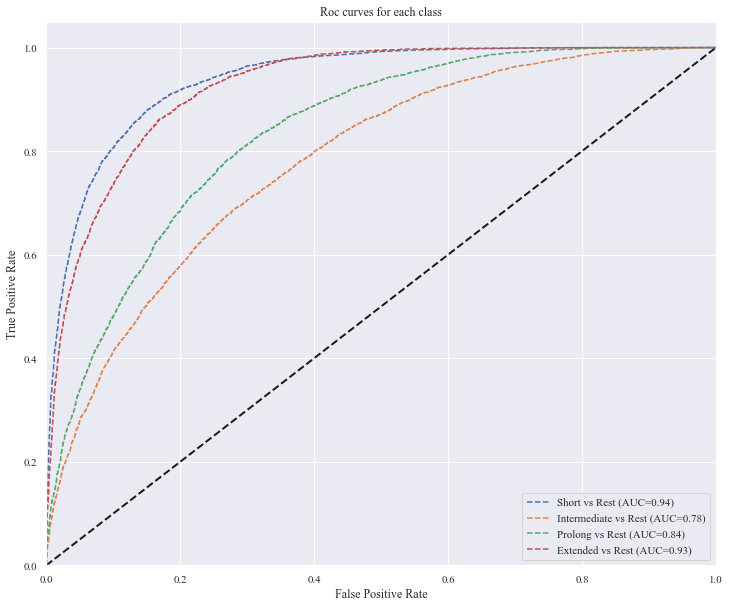

In [39]:
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))
pred_GB = GB.predict_proba(X_test)
fpr = {} 
tpr = {}
roc_auc = {}
n_classes = len(classes)
class_names =['Short','Intermediate','Prolong','Extended']
y_test_binarize = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
#colors = ['blue', 'red', 'green', 'orange', 'purple'] # Define colors for the curves

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_binarize[:,i], pred_GB[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

    plt.plot(fpr[i], tpr[i], linestyle='--', 
            label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))


#plt.plot(fpr[i], tpr[i], linestyle='--', 
            #label='%s vs Rest (AUC=%0.2f)'%(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curves for each class')
plt.legend(loc="lower right")
plt.show()
